# Probabilistic Graphical Models - Lab 2 - Gaussian Mixture and EM algorithm

Guillaume DESFORGES

In [0]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt

np.random.seed(hash('pgm lab2') % 10000)

# Question 1

> In Gaussian Mixture Models, we often need to evaluate quantities that are defined as follows:
> 
> $$\gamma_i(x) = \frac{\pi_i\ \mathcal{N}(x; \mu_i, \Sigma_i)}{\sum_{k=1}^{K}{\pi_k\ \mathcal{N}(x; \mu_k, \Sigma_k)}}$$
> 
> where $\pi_i = \mathbb{P}(Z = i)$ and $\mathcal{N}(\circ ; \mu_k, \Sigma_k)$ denotes the multivariate Gaussian distribution with parameters $\mu_i, \Sigma_i$.
> 
> A direct computation of these quantities might
be problematic in practice since all the terms $(\pi_i\ \mathcal{N}(x; \mu_i
, \Sigma_i))$ might be very small, and we might end up with 0/0.
> 
> Derive mathematically (don’t try to take the derivative!) and implement a function for numerically stable computation
of $\{γ_i\}_{i=1}^K$.
>
> Hint: first compute $l_i = \log (\pi_i\ \mathcal{N}(x; \mu_i, \Sigma_i))$ in a numerically stable way (be careful when computing $\log \det \Sigma_i$). Then
use a trick similar to the one we used for ‘log sum exp’.

Let

\begin{equation}
\begin{split}
l_i(x) & = \log\left(\pi_i\mathcal{N}\left(x, \mu_i, \Sigma_i\right)\right)\\
       & = \log(\pi_i) - \frac{d}{2}\log(2\pi) - \frac{1}{2}\log(\det\Sigma_i) - \frac{1}{2}(x - \mu_i)\,^T\Sigma_i^{-1}(x-\mu_i)\\
\end{split}
\end{equation}

and

$$l_*(x) = \underset{j \in [K]}{\max}(l_j(x))$$

We use a trick similar to the logsumexp trick previously done in lab 1:

\begin{equation}
\begin{split}
\log(\gamma_i(x)) & =      l_i(x) - \log(\sum_{j=1}^K{\exp(l_j)}) \\
                  & \simeq l_i(x) - \left( l_*(x) + \log\sum_{j=1}^K{\exp(l_j(x) - l_*(x))}\right)
\end{split}
\end{equation}

In [0]:
def component_log_likelihood(x, pi_i, mu_i, sigma_i):
    d = sigma_i.shape[0]
    log_det_sigma_i = np.linalg.slogdet(sigma_i)[1]
    return np.log(pi_i) - (d / 2 * np.log(2. * np.pi)) - (log_det_sigma_i / 2) - ((x - mu_i).T @ np.linalg.inv(sigma_i) @ (x - mu_i) / 2)

def components_log_gamma(x, pi, mu, sigma):
    K = pi.shape[0]
    components_log_likelihood = [component_log_likelihood(x, pi[j], mu[j], sigma[j]) for j in range(K)]
    logsumexp_of_likelihoods = logsumexp(components_log_likelihood)
    return np.array([components_log_likelihood[i] - logsumexp_of_likelihoods for i in range(K)])

In [0]:
# test
K = 3
d = 2
np.exp(components_log_gamma(np.zeros(d), np.ones(K)/K, np.zeros((K, d)), np.stack([np.diag(np.ones(d)) for k in range(K)])))

array([0.33333333, 0.33333333, 0.33333333])

# Question 2

> Let us consider a Gaussian Mixture Model (GMM), given as follows:
>
> $$p(x_n) = \sum_{i=1}^K \pi_i\ \mathcal{N} (x_n; \mu_i, \Sigma_i)$$
>
> where $\{x_n\}_{n=1}^N$ is a set of observed data points.
>
> Derive the M-Step of the Expectation-Maximization algorithm for this model, to find $\pi_{1:K}^{(t+1)}$, $\mu_{1:K}^{(t+1)}$ and $\sigma_{1:K}^{(t+1)}$, where $t$ denotes the iteration number.

**E-step**

Let $\forall i \in [K],\ z_i \in {0, 1}$ the random variable indicating if the data was generated from the $i$-th component of the mixture model. 

We can compute

\begin{equation}
\begin{split}
\gamma_i(x) & = p(z_i = 1 \mid x, \theta) \\
            & = \frac{\pi_i\ \mathcal{N}(x; \mu_i, \Sigma_i)}{\sum_{k=1}^{K}{\pi_k\ \mathcal{N}(x; \mu_k, \Sigma_k)}}
\end{split}
\end{equation}

from the Bayes rule.

**M-step**

**Computation of $\pi_i^{(t+1)}$**:

For the mixing coefficients we need only to consider the terms in $\log\pi_i$ but we must introduce a Lagrange multiplier to handle the constraint $\sum \pi_i = 1$, thus we maximize :


\begin{equation}
\begin{split}
  & \underset{\pi_i}{\text{argmax}}
\sum_{n=1}^N \sum_{i=1}^K \gamma_i^{(t)} (x_n) \log \mathcal{N}(x_n, \mu_i, \Sigma_i) + \log(\pi_i)-\lambda(\sum_{i=1}^K\pi_i-1)\\
= & \underset{\pi_i}{\text{argmax}}
\sum_{n=1}^N\sum_{i=1}^K \gamma_i^{(t)} (x_n) \log(\pi_i)+\lambda(\sum_{i=1}^K\pi_i-1)
\end{split}
\end{equation}

Let : 
$$g_1(x)=\sum_{n=1}^N\sum_{i=1}^K \gamma_i^{(t)} (x_n)\log(\pi_i)-\lambda (\sum_{i=1}^{K}\pi_i-1)$$

$\nabla g_1(x)=0 $ ,  which means that,  $ \lambda=\sum_{n=1}^N\sum_{i=1}^K\gamma_i^{(t)} (x_n)=N$
and then we get

$$\pi_{i}^{(t+1)} = \frac{ \sum_{n=1}^{N}\gamma_i^{(t)} (x_n) } { N }$$

Let $N_i = \sum_{n=1}^N\gamma_i^{(t)}(x_n)$

\begin{equation} 
\boxed{ \pi_{i}^{(t+1)} = \frac{N_i } { N } }
\end{equation}
**Computation of $\mu_i^{(t+1)}$:**

We will do it as follow:

\begin{equation}
\begin{split} 
\nabla_{\mu_i}\log(p(x,z|\mu_{1:K},\Sigma_{1:K},\pi_{1:K})
& = \sum_{n=1}^{N} \gamma_i^{(t)}(x_n)\nabla_{\mu_i}\log(p(x_n|\mu_{i},\Sigma_{i})\\ 
& = -\sum_{n=1}^{N} \gamma_i^{(t)} (x_n)\frac{x_n-\mu_i}{\sigma^2}\\
& = 0
\end{split}
\end{equation}

then

$$\mu_{i}^{(t+1)} =\sum_{n=1}^{N} \gamma_i^{(t)} (x_n)\frac{x_n}{\sum_{n=1}^{N} \gamma_i^{(t)} (x_n)}$$

We pass the expectation over $\mu_i$, we obtain :

\begin{equation} 
\mu_{i}^{(t+1)} =  \frac{\sum_n^{N} \gamma_i^{(t)}(x_n) x_n} {\sum_n^{N} \gamma_i^{(t)}(x_n)}
\end{equation} 

Finally,

\begin{equation} 
\boxed{ \mu_{i}^{(t+1)} =  \frac{\sum_n^{N} \gamma_i^{(t)}(x_n)\ x_n} {N_i} }
\end{equation} 
**Computation of $\Sigma_i^{(t+1)}$:**

To do so, we just need derive the first expression w.r.t. $\Sigma_i$:


$$\nabla_{\Sigma_i} \sum_{n=1}^N\gamma_i^t(x_n)(-\frac{1}{2}\Sigma_i^{-1}+\frac{1}{2}\Sigma_i^{-1}(x_n-\mu_i)(x_n-\mu_i)^T\Sigma_i^{-1})=0 $$

and so, we get :

$$ \sum_{n=1}^N\gamma_i^t(x_n)(-\frac{1}{2}I+\frac{1}{2}(x_n-\mu_i)(x_n-\mu_i)^T\Sigma_i^{-1})=0 $$

And then, we just need to multiply by $\Sigma_i$ and we get : 

\begin{equation}
\begin{split}
     & \sum_{n=1}^N\gamma_i^t(x_n)(-\frac{1}{2}\Sigma_i+\frac{1}{2}(x_n-\mu_i)(x_n-\mu_i)^T)=0 \\
\iff & \sum_{n=1}^N\gamma_i^t(x_n)(\Sigma_i-(x_n-\mu_i)(x_n-\mu_i)^T)=0
\end{split}
\end{equation}

We get:

\begin{equation} 
\Sigma_i^{(t+1)} =\frac{\sum_{n=1}^N\gamma_i^t(x_n)(x_n-\mu_i)(x_n-\mu_i)^T}{\sum_{n=1}^N\gamma_i^t(x_n)}
\end{equation} 

Finally,

\begin{equation} 
\boxed{ \Sigma_i^{(t+1)} =\frac{\sum_{n=1}^N\gamma_i^t(x_n)(x_n-\mu_i^{(t+1)})(x_n-\mu_i^{(t+1)})^T}{N_i}}
\end{equation} 


# Question 3
> Consider the model given in Equation 1.
> 
> Set
> 
> * $K = 3$
> * $\pi_1 = 0.3$
> * $\pi_2 = 0.2$
> * $\pi_3 = 0.5$
> * $\mu_1 = [0; 0]$
> * $\mu_2 = [1; 2]$
> * $\mu_3 = [2; 0]$
> * $\sigma_1 = [1.00, −0.25; −0.25, 0.50]$
> * $\sigma_2 = [0.50, 0.25; 0.25, 0.50]$
> * $\sigma_3 = [0.50, −0.25; −0.25, 1]$
> 
> Generate a dataset $\{x_n\}_{n=1}^N$ by using the model definition (set $N = 1000$).
> 
> Visualize the dataset.

In [0]:
K = 3
d = 2

pi = np.array([0.3, 0.2, 0.5])

mu = np.array(
    [
     [0, 0],
     [1, 2],
     [2, 0],
    ]
)

sigma = np.array(
    [
     [[1.00, -0.25],
      [ -0.25, 0.50]],
     [[0.50, 0.25],
      [0.25, 0.50]],
     [[0.50, -0.25],
      [-0.25, 1]]
     ]
)

def generate_dataset(n, pi, mu, sigma):
    K = len(pi)
    x = []
    clusters = []
    for i in range(n):
        x_cluster = np.random.choice(range(3), p=pi)
        clusters.append(x_cluster)
        x.append(np.random.multivariate_normal(mu[x_cluster], sigma[x_cluster]))
    return np.array(clusters), np.array(x)

true_clusters, x = generate_dataset(1000, pi, mu, sigma)

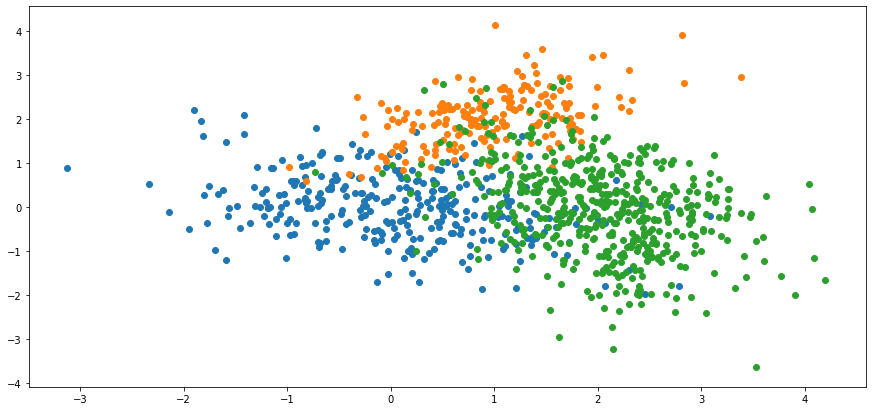

In [0]:
plt.figure(figsize=(15, 7))
for cluster in range(np.max(true_clusters) + 1):
    plt.scatter(x[true_clusters == cluster][:, 0], x[true_clusters == cluster][:, 1])
plt.show()

> Implement the EM algorithm for GMMs (be careful about numerical stability!)

In [0]:
def ellipse_plot(A, mu=np.array([0,0]), col='b'):
    '''
    Creates an ellipse from short line segments y = A x + \mu 
    where x is on the unit circle.
    '''
    n_points = 36
    th = np.linspace(0, 2 * np.pi, n_points)
    X = np.array([np.cos(th), np.sin(th)])
    Y = np.dot(A, X)
    ln = plt.Line2D(mu[0] + Y[0, :], mu[1] + Y[1, :], markeredgecolor='k', linewidth=1, color=col)
    return ln

def plot_distribution(x, mu, sigma, points_clustering, i_iter, colors=['blueviolet', 'darkturquoise', 'y']):
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.sca(ax)
    plt.title(f'Point distribution at iteration : {i_iter}')
    
    for i, color in enumerate(colors):
        A = np.linalg.cholesky(sigma[i])
        plt.scatter(x[points_clustering == i][:, 0], x[points_clustering == i][:, 1], c=color)
        plt.scatter(mu[i, 0], mu[i, 1], marker='4', c=color, s=500)
        ln = ellipse_plot(3 * A, mu[i], color)
        ax.add_line(ln)
    plt.show()

#### Question A
Forget about the true parameters $pi_{1:K}, mu_{1:K}$, and $sigma_{1:K}$ for now. By only considering the dataset {xn}Nn=1
that is generated in the previous step, run the EM algorithm after randomly initializing the parameter
estimates pi
(0)
1:K, mu
(0)
1:K, and sigma(0)
1:K. Visualize the intermediate results by plotting the contours of the estimated
Gaussians.

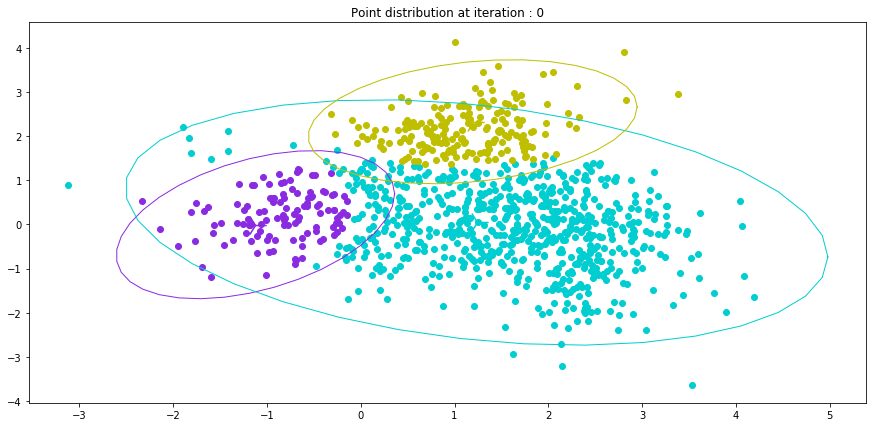

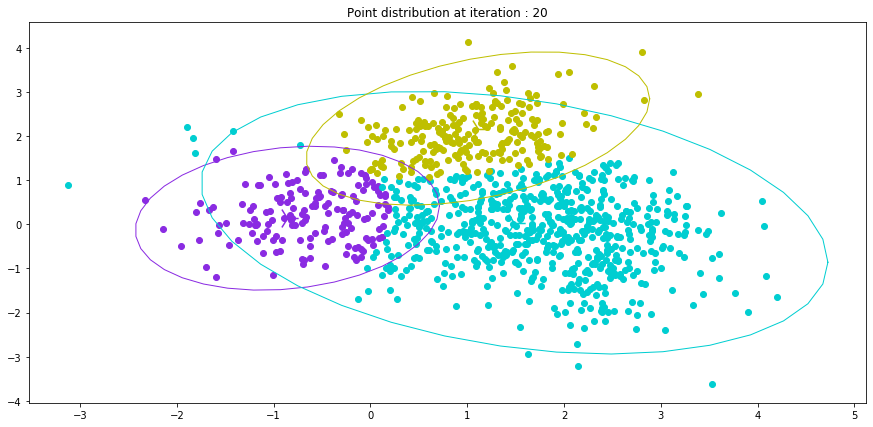

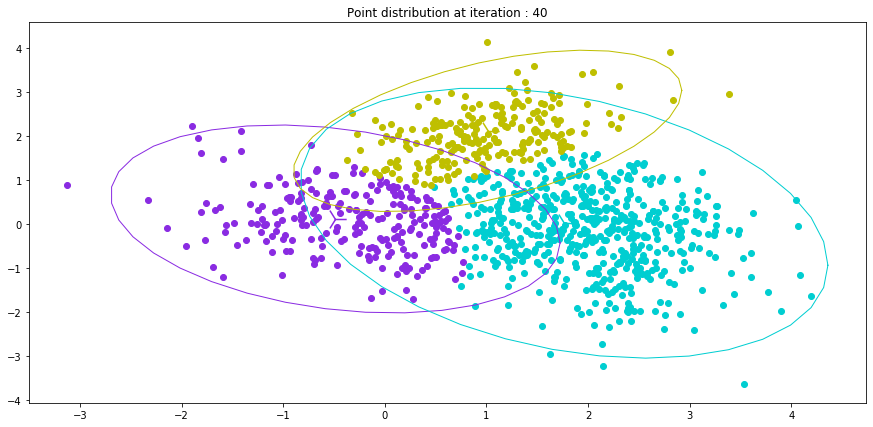

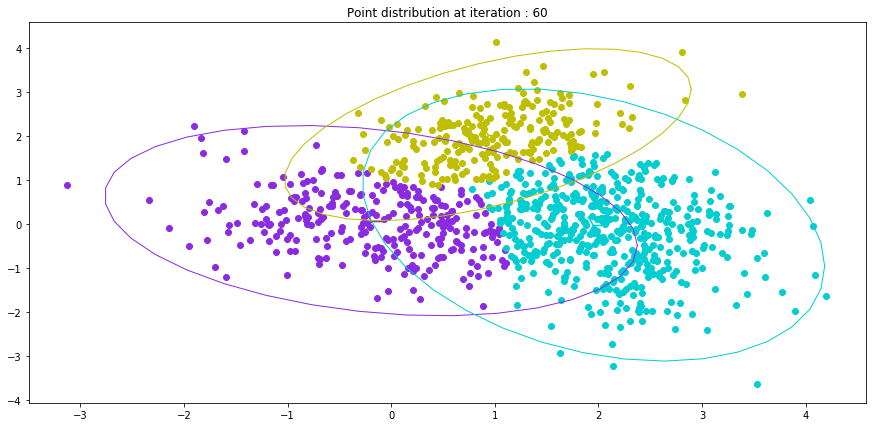

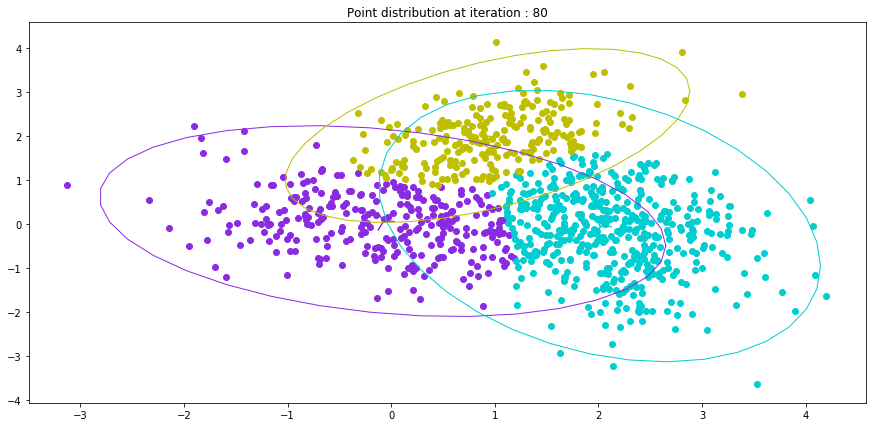

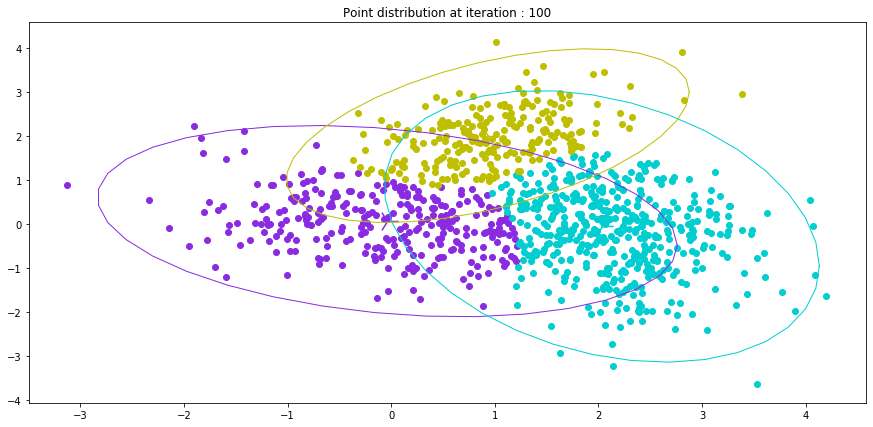

In [0]:
def expectation_maximization_algorithm(x, n_iter, K=None, pi_init=None, mu_init=None, sigma_init=None, plot_every=None):
    pi = pi_init
    
    if pi is None and K is not None:
        pi = np.random.randn(K)
        pi -= pi.min() # normalization (1/2)
        pi += 1e-5 # prevent null
        pi /= pi.sum() # normalization (2/2)
    elif pi is not None and K is None:
        K = len(pi)
    else:
        raise Exception("Only either K or pi_init can be None at a time.")

    N, d = x.shape

    mu = mu_init
    sigma = sigma_init
    
    compute_most_likely_clustering = lambda x, pi, mu, sigma: np.argmax([[np.exp(component_log_likelihood(x[n], pi[i], mu[i], sigma[i])) / pi[i] for i in range(K)] for n in range(N)], axis=1)

    if mu is None:
        mu = np.random.randn(K, d)
    if sigma is None:
        sigma = np.random.randn(K, d, d)

    log_likelihood_logger = []

    for i_iter in range(n_iter):
        # E-step
        gamma = np.exp(np.array([components_log_gamma(x[n], pi, mu, sigma) for n in range(N)]))
        # M-step
        N_vec = np.sum(gamma, axis=0)
        pi = N_vec / N
        mu = np.array([np.sum([gamma[n, k] * x[n] for n in range(N)], axis=0) / N_vec[k] for k in range(K)])
        sigma = np.array([np.sum([gamma[n, k] * (x[n] - mu[k])[..., np.newaxis] @ (x[n] - mu[k])[..., np.newaxis].T for n in range(N)], axis=0) / N_vec[k] for k in range(K)])

        log_likelihood_logger += [sum([logsumexp([component_log_likelihood(x[n], pi[i], mu[i], sigma[i]) for i in range(K)]) for n in range(N)])/N]

        if plot_every is not None and i_iter % plot_every == 0:
            most_likely_point_clustering = compute_most_likely_clustering(x, pi, mu, sigma)
            plot_distribution(x, mu, sigma, most_likely_point_clustering, i_iter)

    most_likely_point_clustering = compute_most_likely_clustering(x, pi, mu, sigma)
    return pi, mu, sigma, most_likely_point_clustering, log_likelihood_logger

results = expectation_maximization_algorithm(x, n_iter=120, K=K, plot_every=20)

#### Question B

While running the EM algorithm, compute the log-likelihood. Plot the log-likelihood vs iterations (be
careful about numerical stability!).

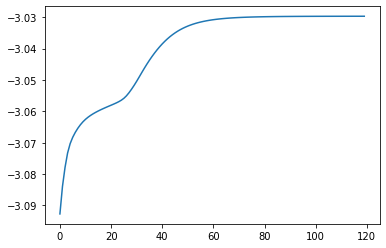

In [0]:
plt.plot(results[-1])

#### Question C 
Run the EM algorithm with different initializations for pi
(0)
1:K, mu
(0)
1:K, and sigma(0)
1:K. How sensitive is the algorithm
for different initial values?

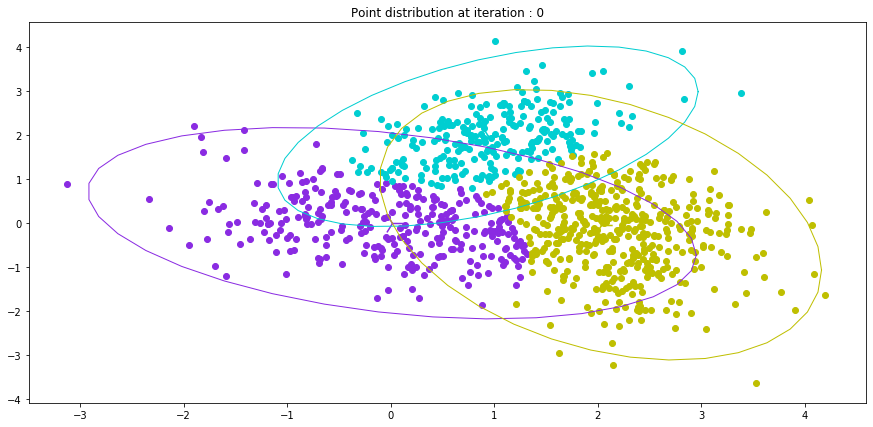

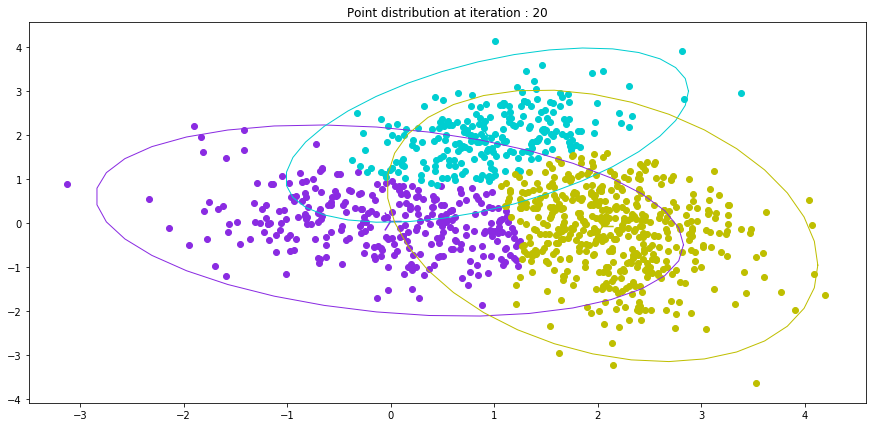

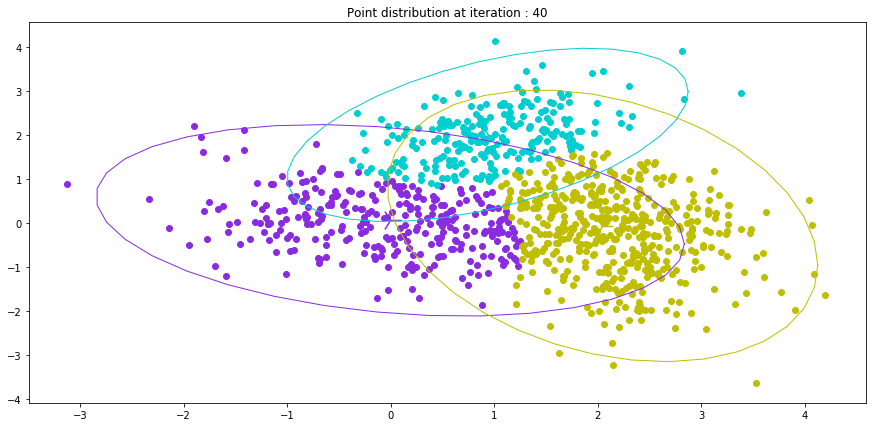

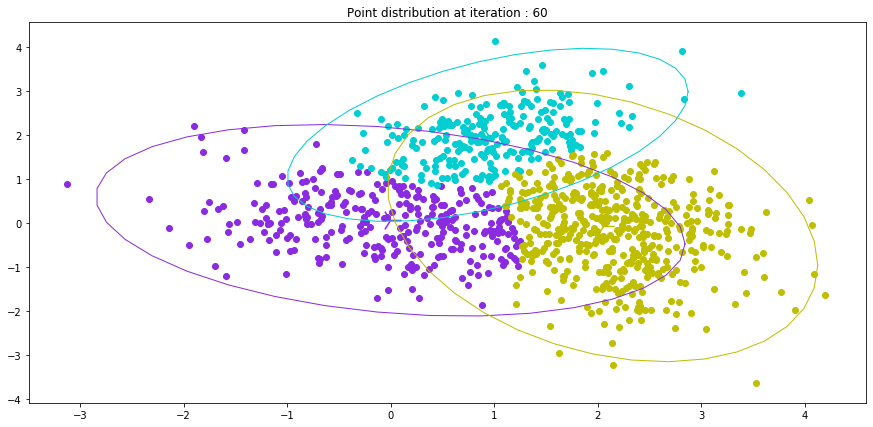

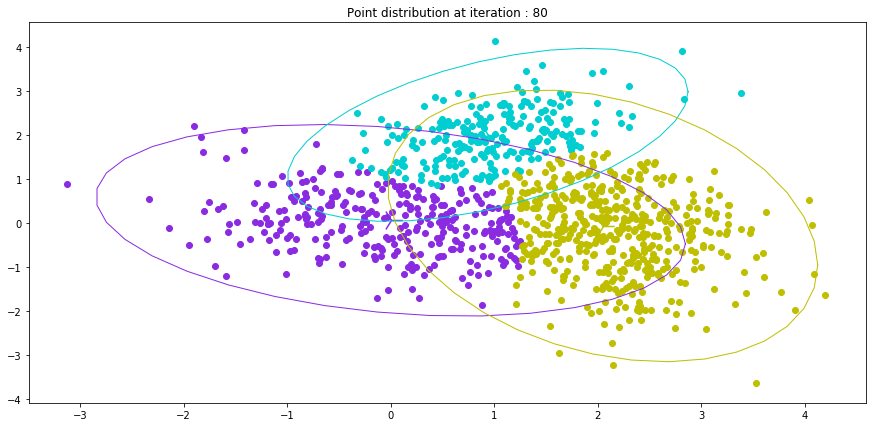

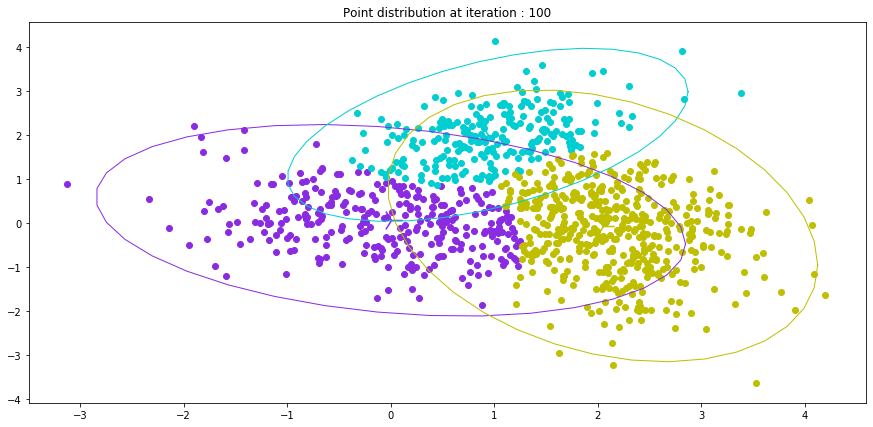

In [0]:
results_fixed = expectation_maximization_algorithm(x, n_iter=120, K=None, pi_init=pi, mu_init=mu, sigma_init=sigma, plot_every=20)

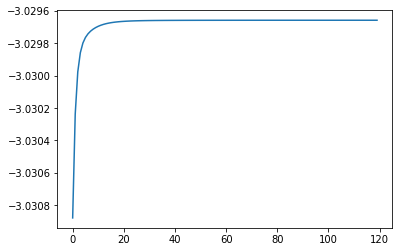

In [0]:
plt.plot(results_fixed[-1])

# Conclusion

Text(0, 0.5, 'Log likelihood value')

<Figure size 432x288 with 0 Axes>

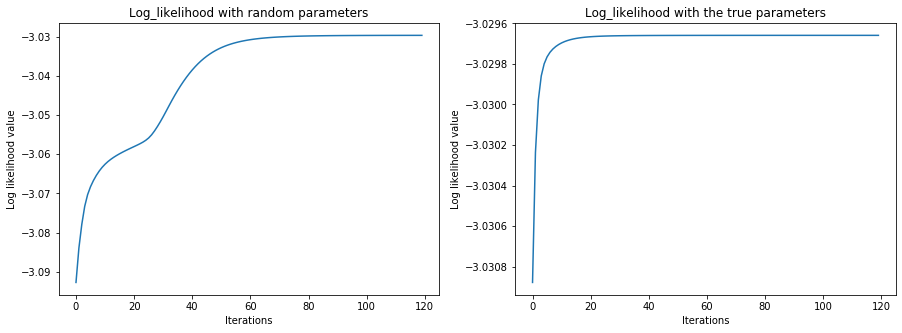

In [0]:
fig = plt.figure()

f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(results[-1])
ax2.plot(results_fixed[-1])

ax1.set_title("Log_likelihood with random parameters")
ax2.set_title("Log_likelihood with the true parameters")

ax1.set_xlabel("Iterations")
ax2.set_xlabel("Iterations")

ax1.set_ylabel("Log likelihood value")
ax2.set_ylabel("Log likelihood value")

We observe that the point distribution within the clusters are  different if we give the EM algorithm fixed parameters. With random parameters, the repartition of points between clusters seems a bit odd while it seems much more natural with the fixed parameters.

Observing the evolution of the log-likelihood following the iterations, we notice a slight difference, the one that comes from fixed parameters being more smooth than the random one.

Eventually, around 100 iterations later, the clustering is the same. We conclude that with fixed parameters, the clustering is much faster (requires less iterations).

